<a href="https://colab.research.google.com/github/james-hughes1/wdss-nlp-project/blob/main/Exploratory_Analysis_COP26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preamble

In [1]:
# Import libraries
# Data Processing
import pandas as pd
import numpy as np
import re
import datetime as dt
import random

# Statistical Modelling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Files
import os
import zipfile

In [2]:
# Function to make colormap of scatter plots uniform

def scatter_cmap(colours):
    colours_unique = list(set(colours))
    colours_unique.sort()
    n = len(colours_unique)
    colours_scaled = []
    for c in colours:
        colours_scaled.append(colours_unique.index(c)/n)
    return colours_unique, colours_scaled


In [3]:
# Download the GloVe embedding data
# This may take upto 3 minutes

!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2023-01-30 12:28:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-30 12:28:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-30 12:28:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [4]:
# Read and format the twitter scrape .csv file
# Add the .csv file to the workspace or this won't work

dateparse = lambda dates: [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in dates]

tweets_df = pd.read_csv("Twitter Scrape 2_Reduced.csv", usecols=['ID', 'Date', 'Likes', 'Replies', 'Retweets', 'User ID', 'Username', 
                                                                 'Followers', 'Verified', 'Content', 'Time', 'Category'],
                        date_parser = dateparse, parse_dates=["Date"], encoding="UTF-8")
tweets_df["Time"] = pd.to_datetime(tweets_df["Time"], format='%H:%M:%S').dt.time
tweets_df["Date"] = pd.to_datetime(tweets_df["Date"], format='%H:%M:%S').dt.date

In [5]:
# Dendogram plotting function

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(18,16))
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [6]:
# Extract GloVe embedding data

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Text Pre-Processing

In [7]:
# Use regex to clean tweets
tweets_clean = []

for i in range(len(tweets_df)):
    tweet_raw = tweets_df["Content"][i]
    tweet_edit_1 = re.sub("http\S+", "", tweet_raw.lower())
    tweet_edit_2 = re.sub("&amp;", "and", tweet_edit_1)
    tweet_edit_3 = re.sub(r"[^@#%$£\w\⁠s,. ]", "", tweet_edit_2) # Filter emojis
    tweet_edit_4 = re.sub("[.,:;'\"] | [.,:;'\"]", " ", tweet_edit_3)
    tweets_clean.append(tweet_edit_4.strip())

In [8]:
# Sample cleaned tweets

tweets_clean[0]

'everyone should be doing it or none at allanger is mounting in scotland after it was revealed up to 30,000 cop26 delegates will not have to show their vaccine status  despite covid passports being introduced in scotland'

In [9]:
# Preprocessing hyperparameters

vocab_size = 20000
max_length = 24

# Tokenize text data

tokenizer = Tokenizer(oov_token="<OOV>",
                    num_words=vocab_size,
                    filters="")
tokenizer.fit_on_texts(tweets_clean)

In [10]:
# Construct word frequency dataframe

freq_analysis_df = pd.DataFrame(data = dict(tokenizer.word_counts).items(),
                                columns = ["Word", "Count"]).sort_values(by="Count",ascending=False)

In [11]:
# Build embedding_matrix

word_index = list(freq_analysis_df["Word"])
embedding_matrix = np.zeros((len(word_index), 100))
for i, word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Stop Words

In [12]:
nltk.download("stopwords")
stop_words = list(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
print("Fraction stop words: ", np.sum(freq_analysis_df[freq_analysis_df["Word"].isin(stop_words)]["Count"])/np.sum(freq_analysis_df["Count"]))

Fraction stop words:  0.38103711746491337


In [14]:
freq_analysis_df[freq_analysis_df["Count"]==1]

,Word,Count
7692,outtickets,1
7397,filled,1
7698,thriller,1
7398,efficacy,1
8289,plucked,1
...,...,...
5668,hitech,1
5666,@gatesfoundation,1
5664,groundbreaking,1
5663,surge,1


## Lexicon-Level Analysis

In [15]:
# Word Frequencies

freq_analysis_df.head(50)

,Word,Count
51,the,4866
17,to,3570
62,#cop26,2403
35,and,2393
57,of,2252
120,a,1560
83,climate,1540
11,in,1505
7,at,1183
9,is,1129


###Clustering

In [16]:
# Construct non-zero embedding matrix and assign cluster zero

freq_analysis_df["Cluster"] = -1
embeddings = []
valid_word_index = []
for i, row in enumerate(embedding_matrix):
    if (row==0).all():
        freq_analysis_df.iloc[i,2] = 0
    else:
        valid_word_index.append(i)
        embeddings.append(row)
embedding_matrix_nz = np.array(embeddings)

In [17]:
# Number of words not included in GloVe model

count1 = 0
count2 = 0
for row in freq_analysis_df[freq_analysis_df["Cluster"]==0]["Word"]:
  if "#" in row:
    count1+=1
  if "@" in row:
    count2+=1
print("Number of words unknown to GloVe: ", len(freq_analysis_df[freq_analysis_df["Cluster"]==0]))
print("Number of unique hashtags: ", count1)
print("Number of unique user @'s: ", count2)

Number of words unknown to GloVe:  2928
Number of unique hashtags:  512
Number of unique user @'s:  671


In [18]:
# Agglomerative Clustering (to produce dendrogram, not for actual cluster assignments)

num_clusters_words = 50
clustering_agg_words = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1,
                                               affinity="cosine", linkage="average").fit(normalize(embedding_matrix_nz, axis=1))

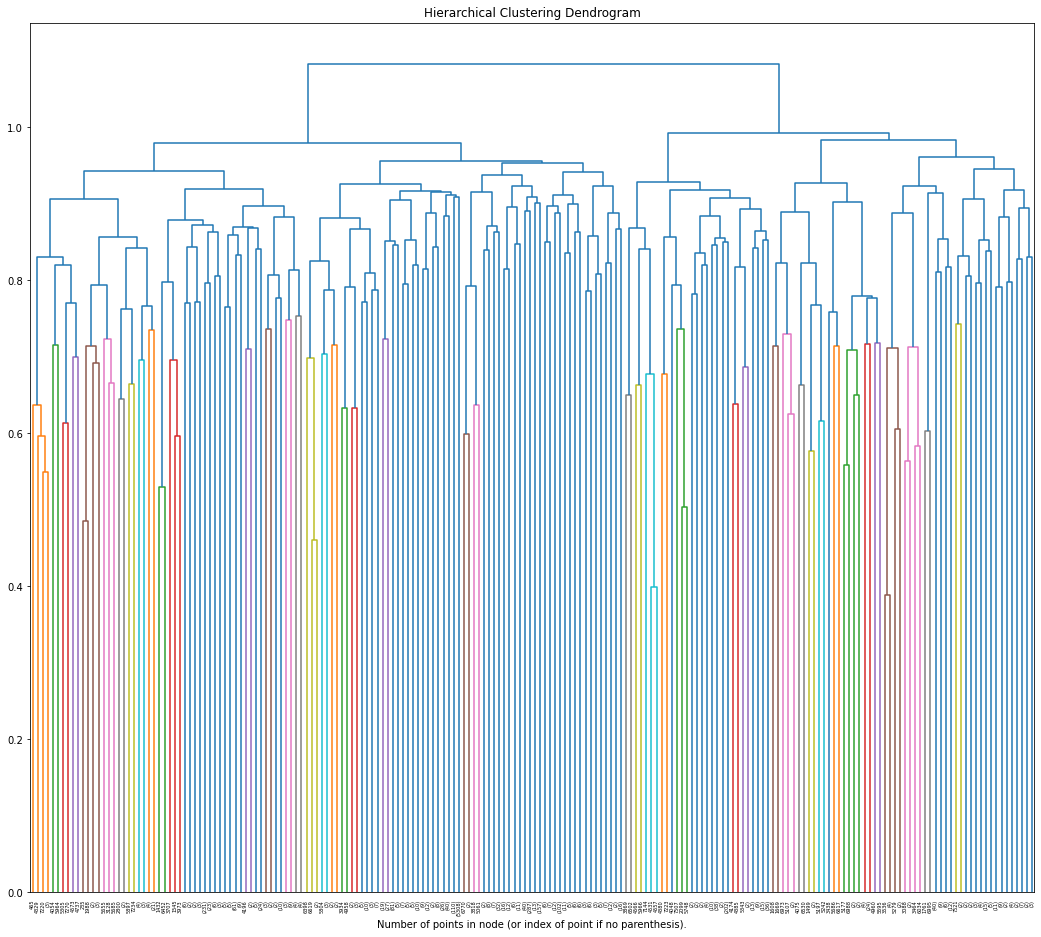

In [19]:
# Plot Dendrogram
# This cell only functions if n_clusters is not specified in the agglomerative clustering

plot_dendrogram(clustering_agg_words, truncate_mode="level", p=7)

In [20]:
# K-Means Clustering

num_clusters_words = 50
# L2 normalising the embeddings makes K-means euclidean clustering the same as K-means cosine similarity clustering
kmeans_words = KMeans(n_clusters=num_clusters_words-1, random_state=0, n_init=10).fit(normalize(embedding_matrix_nz, axis=1))
for i in range(len(valid_word_index)):
    # We reserve zero for words that don't belong to the GloVe model.
    freq_analysis_df.iloc[valid_word_index[i],2] = kmeans_words.labels_[i]+1

In [21]:
# Display Cluster Information

for k in range(num_clusters_words):
  print("\nCluster: ",k)
  cluster_df = freq_analysis_df[freq_analysis_df["Cluster"]==k]
  print(len(cluster_df)/len(freq_analysis_df))
  print("Average Word Count: ", np.mean(cluster_df["Count"]))
  print(freq_analysis_df[freq_analysis_df["Cluster"]==k].iloc[:30])


Cluster:  0
0.2788305875630892
Average Word Count:  3.282103825136612
                       Word  Count  Cluster
62                   #cop26   2403        0
3747           @jeegeronimo    748        0
19                    cop26    721        0
7046      @jeegeronimowatch    147        0
79           #climateaction    133        0
824   #togetherforourplanet    116        0
636              @piaranada    107        0
7031     @jeegeronimo#cop26     82        0
2774           #rapplertalk     77        0
4611            #cop26watch     72        0
1016                 @cop26     70        0
454                   icymi     46        0
281       #climateemergency     43        0
3220               @skynews     42        0
92          @nicolasturgeon     40        0
714                    1.5c     38        0
471          #climatechange     36        0
2164  #dontchooseextinction     36        0
278          #climatecrisis     34        0
1290          #cop26glasgow     32        0
2727 

In [22]:
# More detail about a specific cluster

freq_analysis_df[freq_analysis_df["Cluster"]==26].head(50)

,Word,Count,Cluster
187,world,500,26
90,ahead,121,26
71,event,54,26
1513,worlds,51,26
1034,final,49,26
487,goal,43,26
515,goals,39,26
156,opening,34,26
2263,lead,29,26
792,best,23,26


### PCA Visualisation of Lexicon Clusters

In [23]:
# Compute first three principal components of word embedding data

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
embedding_matrix_pc = pca.fit_transform(embedding_matrix)
freq_analysis_df["PC1"] = embedding_matrix_pc[:,0]
freq_analysis_df["PC2"] = embedding_matrix_pc[:,1]
freq_analysis_df["PC3"] = embedding_matrix_pc[:,2]

In [24]:
pca.explained_variance_ratio_

array([0.12457109, 0.04273413, 0.03550266])

In [25]:
# Filter dataframe for plotting

freq_analysis_df_filtered = freq_analysis_df[freq_analysis_df["Cluster"].isin([2,3,20,36,45]) & (freq_analysis_df["Count"]>0)]

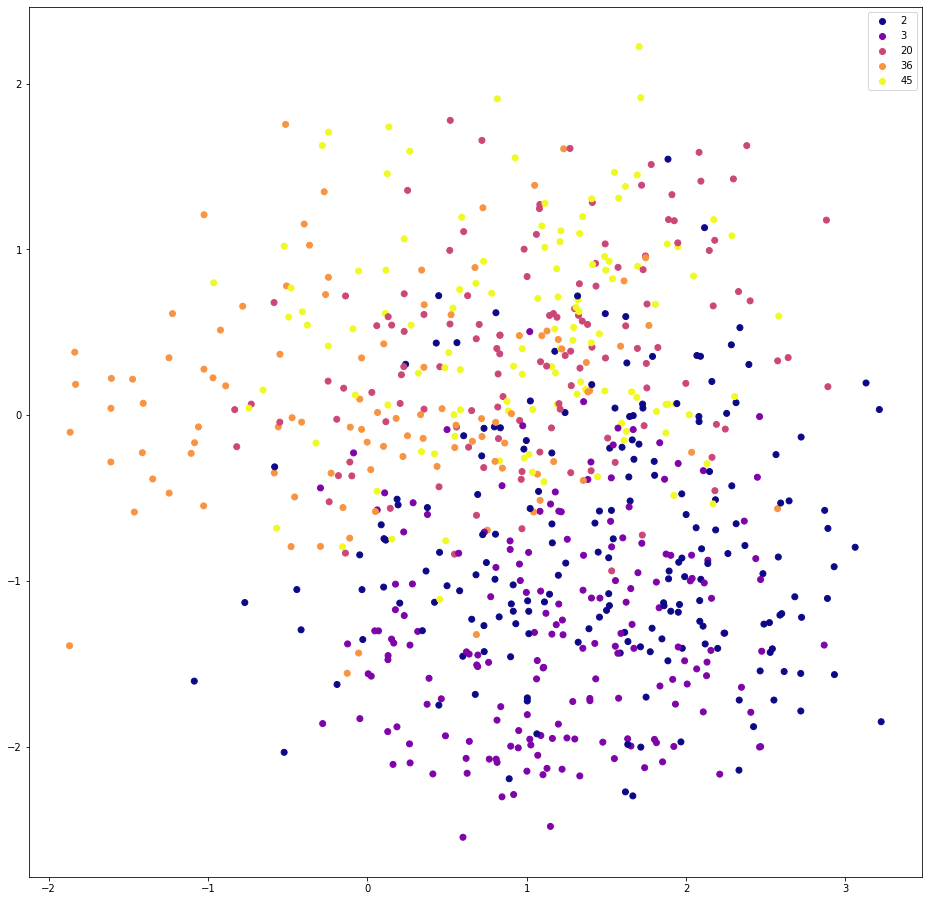

In [26]:
# 2D PC Plot

colours_unique, colours_scaled = scatter_cmap(list(freq_analysis_df_filtered["Cluster"]))

plt.figure(figsize=(16,16))
scatter = plt.scatter(freq_analysis_df_filtered["PC1"],
            freq_analysis_df_filtered["PC2"],
            c=colours_scaled,
            cmap = "plasma")
handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique)
plt.show()

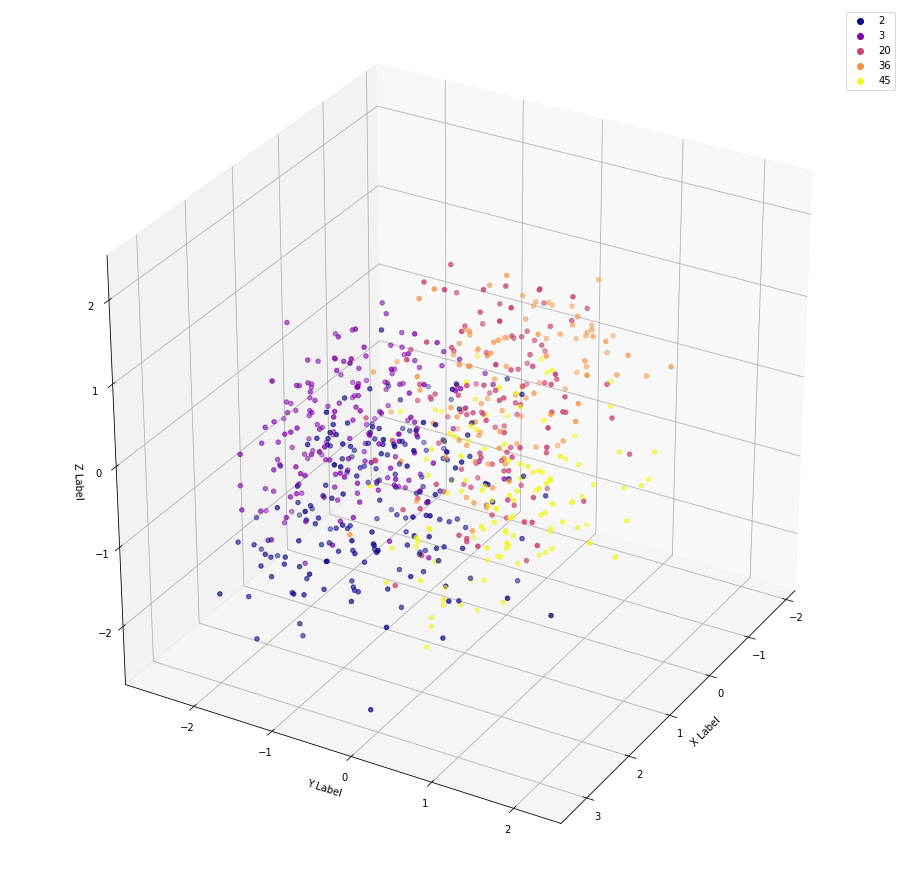

In [27]:
# 3D PC Plot

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')

colours_unique, colours_scaled = scatter_cmap(list(freq_analysis_df_filtered["Cluster"]))

scatter = ax.scatter(freq_analysis_df_filtered["PC1"],
           freq_analysis_df_filtered["PC2"],
           freq_analysis_df_filtered["PC3"],
           c=colours_scaled,
          cmap = "plasma")

handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique)

ax.view_init(30, 30)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Tweet-Level Analysis

### Average Embedding Vector Clustering

In [28]:
# Create an average embedding vector for each tweet
# Ignore stop words

tweet_sequences = tokenizer.texts_to_sequences(tweets_clean)
stop_words_tokens = tokenizer.texts_to_sequences([stop_words])[0]

tweet_embedding_avg_matrix = np.zeros((len(tweets_df), 100))
for i in range(len(tweets_df)):
    vector_sum = np.zeros(100)
    for token in tweet_sequences[i]:
        vector_sum += embedding_matrix[token - 2]
    tweet_embedding_avg_matrix[i] = vector_sum
tweet_embedding_avg_matrix = normalize(tweet_embedding_avg_matrix, axis=1)
tweets_df = pd.concat([tweets_df,
                                 pd.DataFrame(data=tweet_embedding_avg_matrix, columns=["ec"+str(i) for i in range(100)])],
                                 axis=1)

In [29]:
# Average embedding vector clustering (agglomerative)

num_clusters_tweets = 8
clustering_agg_tweets_avg = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1,
                                                    linkage="complete", affinity="cosine").fit(tweet_embedding_avg_matrix)

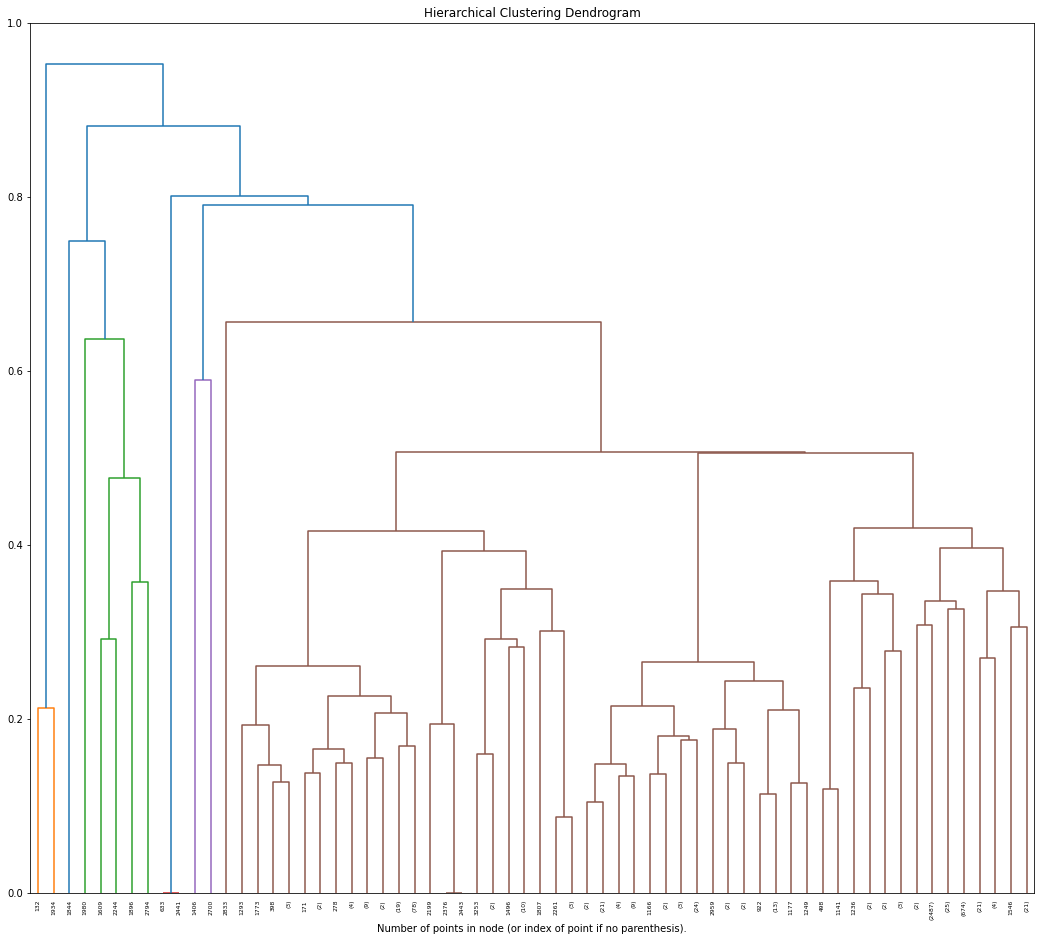

In [30]:
plot_dendrogram(clustering_agg_tweets_avg, truncate_mode="level", p=10)

In [31]:
# Average embedding vector clustering (kmeans)

num_clusters_tweets = 8
kmeans_tweets_avg = KMeans(n_clusters=num_clusters_tweets, random_state=0, n_init=10).fit(tweet_embedding_avg_matrix)
tweets_df["Cluster"] = kmeans_tweets_avg.labels_

### Cluster Exploration

In [32]:
# Display information about each cluster

for k in range(num_clusters_tweets):
    print("\nCluster: ",k)
    cluster_df = tweets_df[tweets_df["Cluster"]==k]
    print("Fraction of Data: ", len(cluster_df)/len(tweets_df))
    print("Average Likes: ", np.mean(cluster_df["Likes"]))
    for i in range(3):
        if i< len(cluster_df):
            print(cluster_df.sort_values(by="Likes", ascending=False).iloc[i,9])


Cluster:  0
Fraction of Data:  0.1874462596732588
Average Likes:  1479.31498470948
I am pleased to announce that I’ve decided to go net-zero on swear words and bad language. In the event that I should say something inappropriate I pledge to compensate that by saying something nice. #COP26
We can still realise what was promised in Paris 2015. We can still save our planet. We can still save our future. 🌍 
WATCH our message to world leaders at today’s UN Climate Change Conference – COP26 in #Glasgow
#ClimateActionInYourArea #TogetherForOurPlanet #BLINKS @COP26 https://t.co/nUyEDGZr36
When you’re sitting next to 95-year-old Sir David Attenborough and you *still* can’t be arsed to wear a mask.

Or even stay awake. #COP26 https://t.co/xrhXUMky2F

Cluster:  1
Fraction of Data:  0.1940384064201777
Average Likes:  942.6838995568685
#COP26 has been named the must excluding COP ever.

This is no longer a climate conference.

This is a Global North greenwash festival.

A two week celebration of b

In [47]:
# Tweets from a specific cluster

list(tweets_df[tweets_df["Cluster"]==4].sort_values(by="Likes", ascending=False)["Content"].iloc[:50])

['Trainwreck. \n#wearamask #COP26Glasgow #DavidAttenborough #cop26  https://t.co/FYVCIXVfv4',
 'LIVE: Former U.S. President Barack Obama addresses #COP26 https://t.co/NfbaoZe8hG',
 'WATCH: Former U.S. President Barack Obama speaks at #Cop26 https://t.co/UKqEiXoZuK https://t.co/0saAVdc1Ty',
 'LIVE: #COP26 presidency holds news conference https://t.co/ib5gFMCTos',
 'LIVE: Prime Minister Boris Johnson addresses UK parliament on COP26, COVID https://t.co/EW25FQ20YO',
 'LIVE: UK Prime Minister Johnson speaks at COP26 https://t.co/agRZn7rErU',
 'Biggest carbon emitter blame game troubles COP26 talks https://t.co/MgUF0RIOKZ https://t.co/lVu30iWY9L',
 'HAPPENING NOW AT #COP26: High level segment\n\nWATCH: https://t.co/xIyjjcxAxG\n\nUPDATES: https://t.co/B9QpAIGnR4',
 '#COP26 begins.\n\nLIVE UPDATES: https://t.co/B9QpAIoMsu',
 'NOW: Former US president Barack Obama to address COP26. \n\n#COP26 UPDATES: https://t.co/B9QpAIoMsu',
 '#COP26: Destination 2030 https://t.co/Gl58CrKb2c',
 'NOW at #COP2

In [34]:
# Group tweets_df by category and cluster

tweets_cat_clust_df = pd.DataFrame(tweets_df["Date"].unique())
tweets_cat_clust_df = tweets_cat_clust_df.merge(pd.DataFrame(tweets_df["Category"].unique()), how="cross")
tweets_cat_clust_df = tweets_cat_clust_df.merge(pd.DataFrame(tweets_df["Cluster"].unique()), how="cross")
tweets_cat_clust_df = pd.DataFrame(np.array(tweets_cat_clust_df),
                                   columns = ["Date", "Category", "Cluster"])
tweets_cat_clust_df = tweets_cat_clust_df.merge(tweets_df.groupby(["Date", "Category", "Cluster"]).count().rename(columns={"ID":"Count"})["Count"],
                                                how="left", on=["Date", "Category", "Cluster"])
tweets_cat_clust_df = tweets_cat_clust_df.merge(tweets_df.groupby(["Date", "Category", "Cluster"]).sum()["Likes"],
                                                how="left", on=["Date", "Category", "Cluster"])
tweets_cat_clust_df.fillna(0,inplace=True)
tweets_cat_clust_df.sort_values(by = ["Date", "Category", "Cluster"], inplace=True)
tweets_cat_clust_df.reset_index(inplace=True)
tweets_cat_clust_df

,index,Date,Category,Cluster,Count,Likes
0,33,2021-10-14,Activist,0,1.0,37.0
1,34,2021-10-14,Activist,1,0.0,0.0
2,35,2021-10-14,Activist,2,0.0,0.0
3,32,2021-10-14,Activist,3,0.0,0.0
4,39,2021-10-14,Activist,4,0.0,0.0
...,...,...,...,...,...,...
3235,3232,2021-11-27,Scientist,3,0.0,0.0
3236,3239,2021-11-27,Scientist,4,0.0,0.0
3237,3236,2021-11-27,Scientist,5,0.0,0.0
3238,3238,2021-11-27,Scientist,6,0.0,0.0


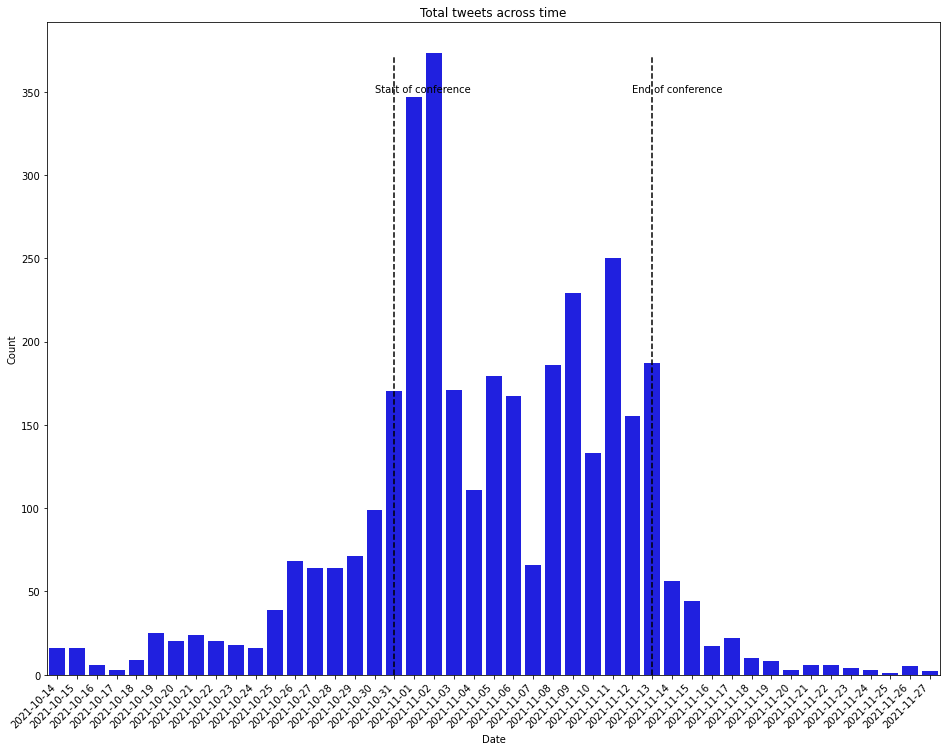

In [35]:
# Total tweet counts time series

plt.figure(figsize=(16,12))
bar = sns.barplot(data=tweets_cat_clust_df.groupby(["Date"]).sum().reset_index(), x="Date", y="Count", color="blue", ci=None)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Total tweets across time")
plt.axvline(17, 0, 0.95 , color="black", linestyle="--")
plt.axvline(30, 0, 0.95 , color="black", linestyle="--")
plt.text(16, 350, "Start of conference")
plt.text(29, 350, "End of conference")
plt.show()

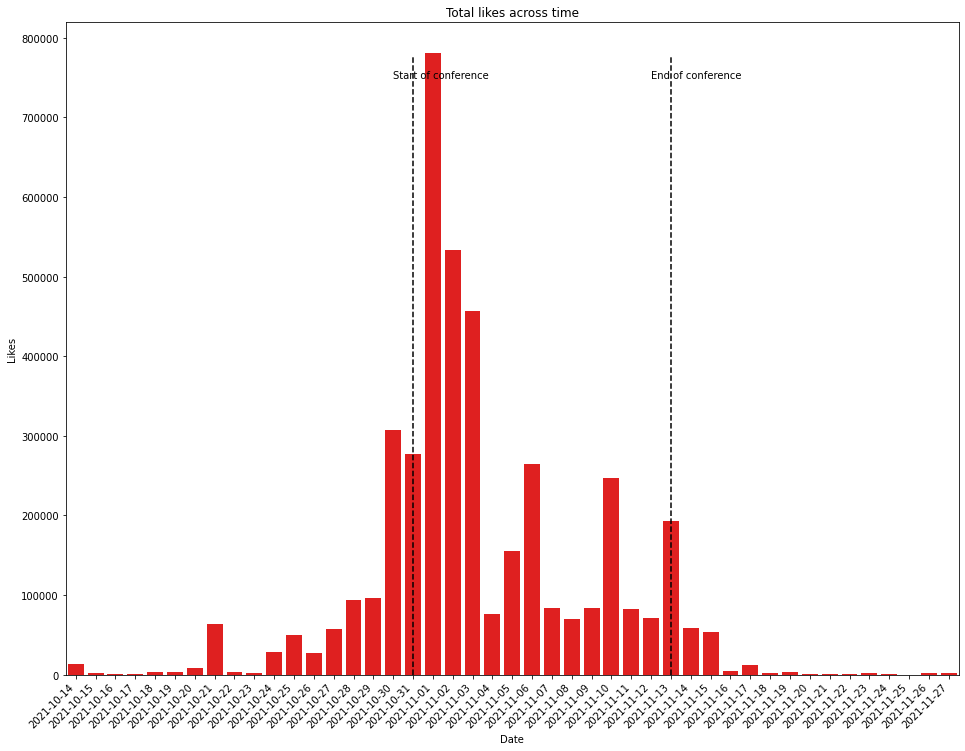

In [36]:
# Total tweet likes time series

plt.figure(figsize=(16,12))
bar = sns.barplot(data=tweets_cat_clust_df.groupby(["Date"]).sum().reset_index(), x="Date", y="Likes", color="red", ci=None, )
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Total likes across time")
plt.axvline(17, 0, 0.95 , color="black", linestyle="--")
plt.axvline(30, 0, 0.95 , color="black", linestyle="--")
plt.text(16, 750000, "Start of conference")
plt.text(29, 750000, "End of conference")
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

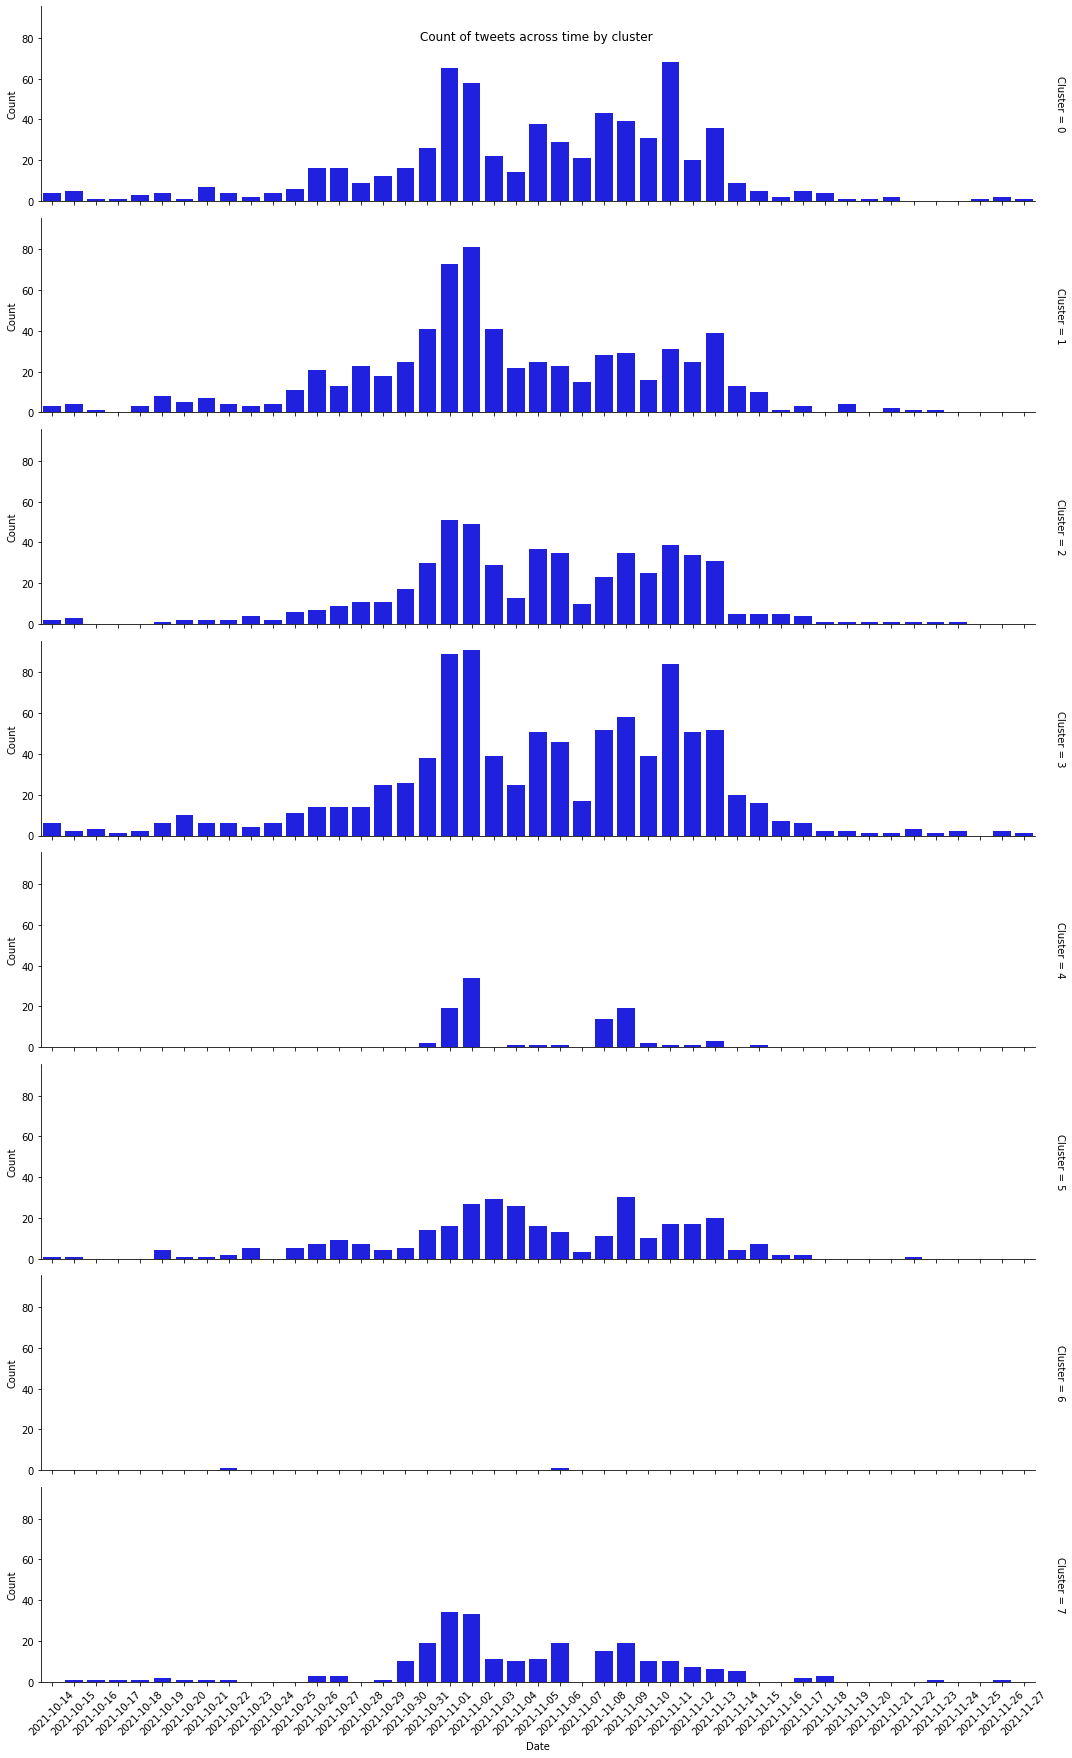

In [37]:
# Count of Tweets Across Time by Cluster

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Cluster"]).sum().reset_index(),
                  row="Cluster", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Count", ci=None, color="blue")
g.fig.suptitle("Count of tweets across time by cluster")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

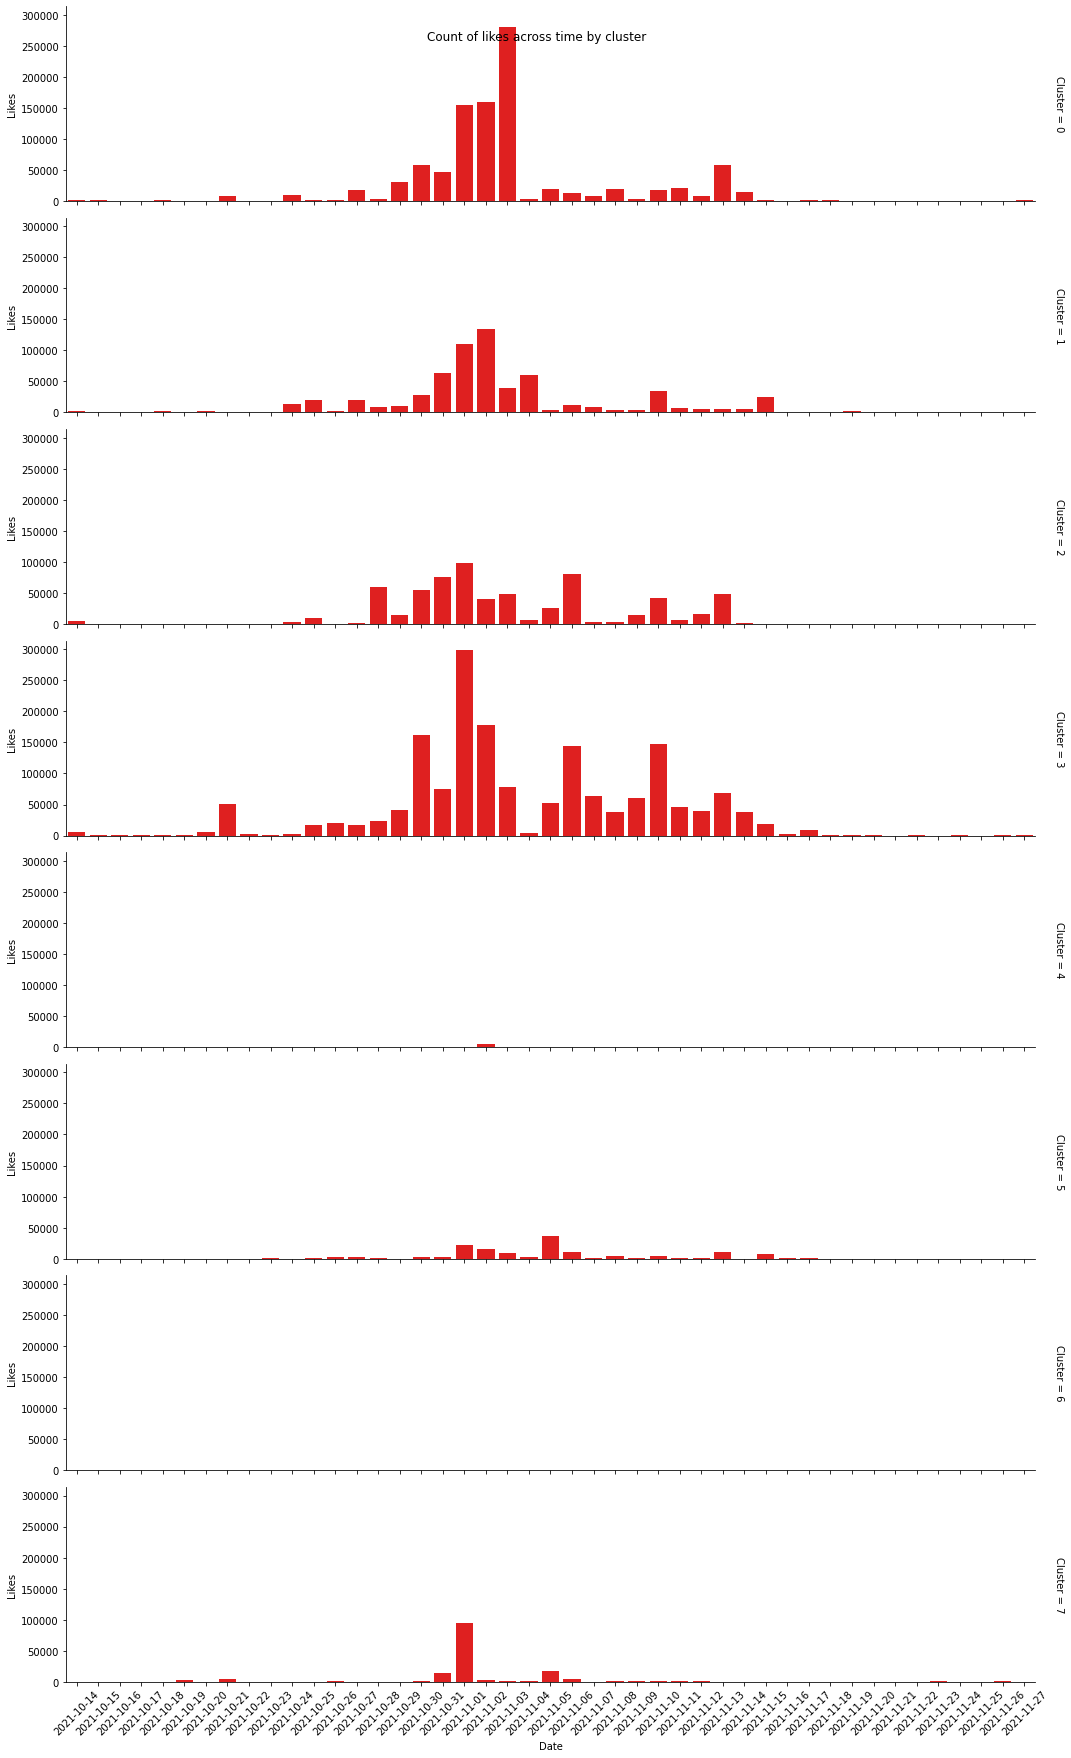

In [38]:
# Tweet Likes Across Time by Cluster

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Cluster"]).sum().reset_index(),
                  row="Cluster", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Likes", ci=None, color="red")
g.fig.suptitle("Count of likes across time by cluster")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

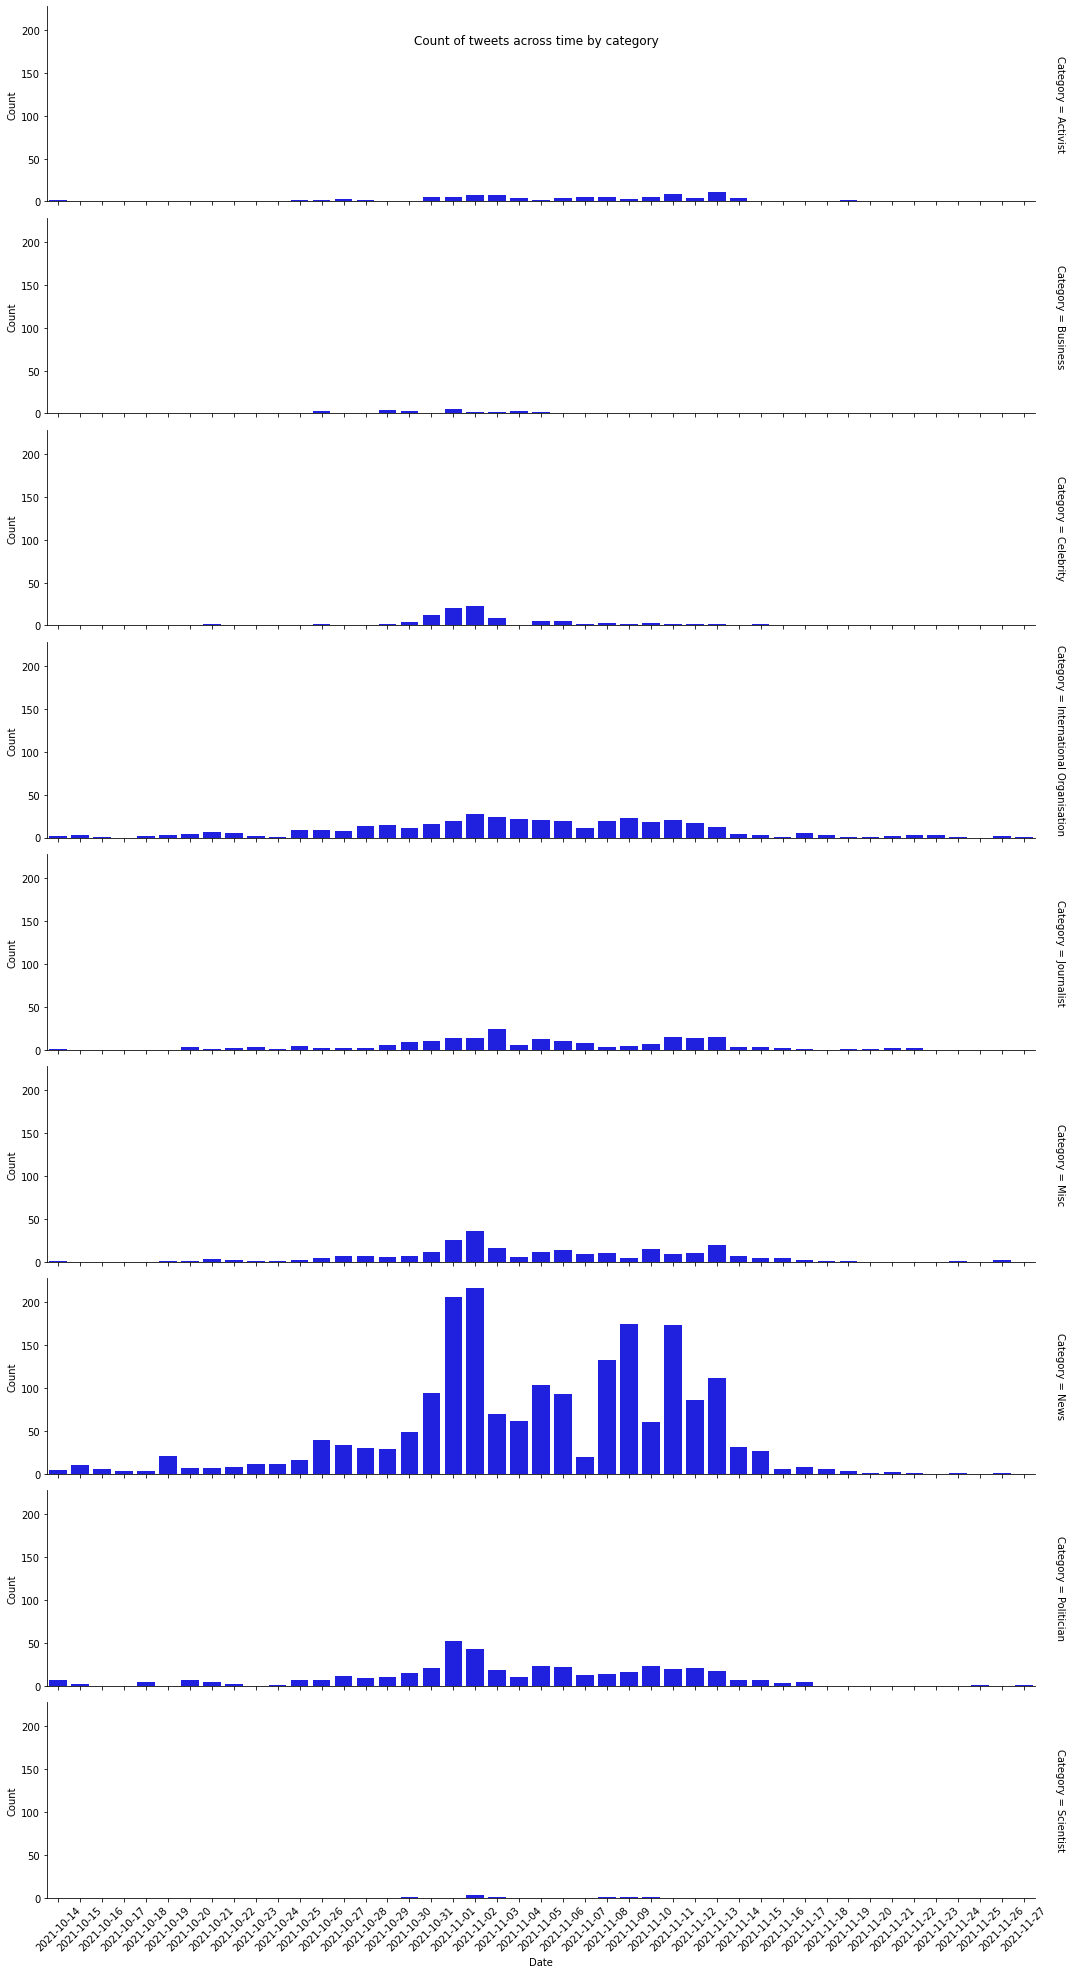

In [39]:
# Tweet Counts Across Time by Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Category"]).sum().reset_index(), row="Category", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Count", ci=None, color="blue")
g.fig.suptitle("Count of tweets across time by category")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

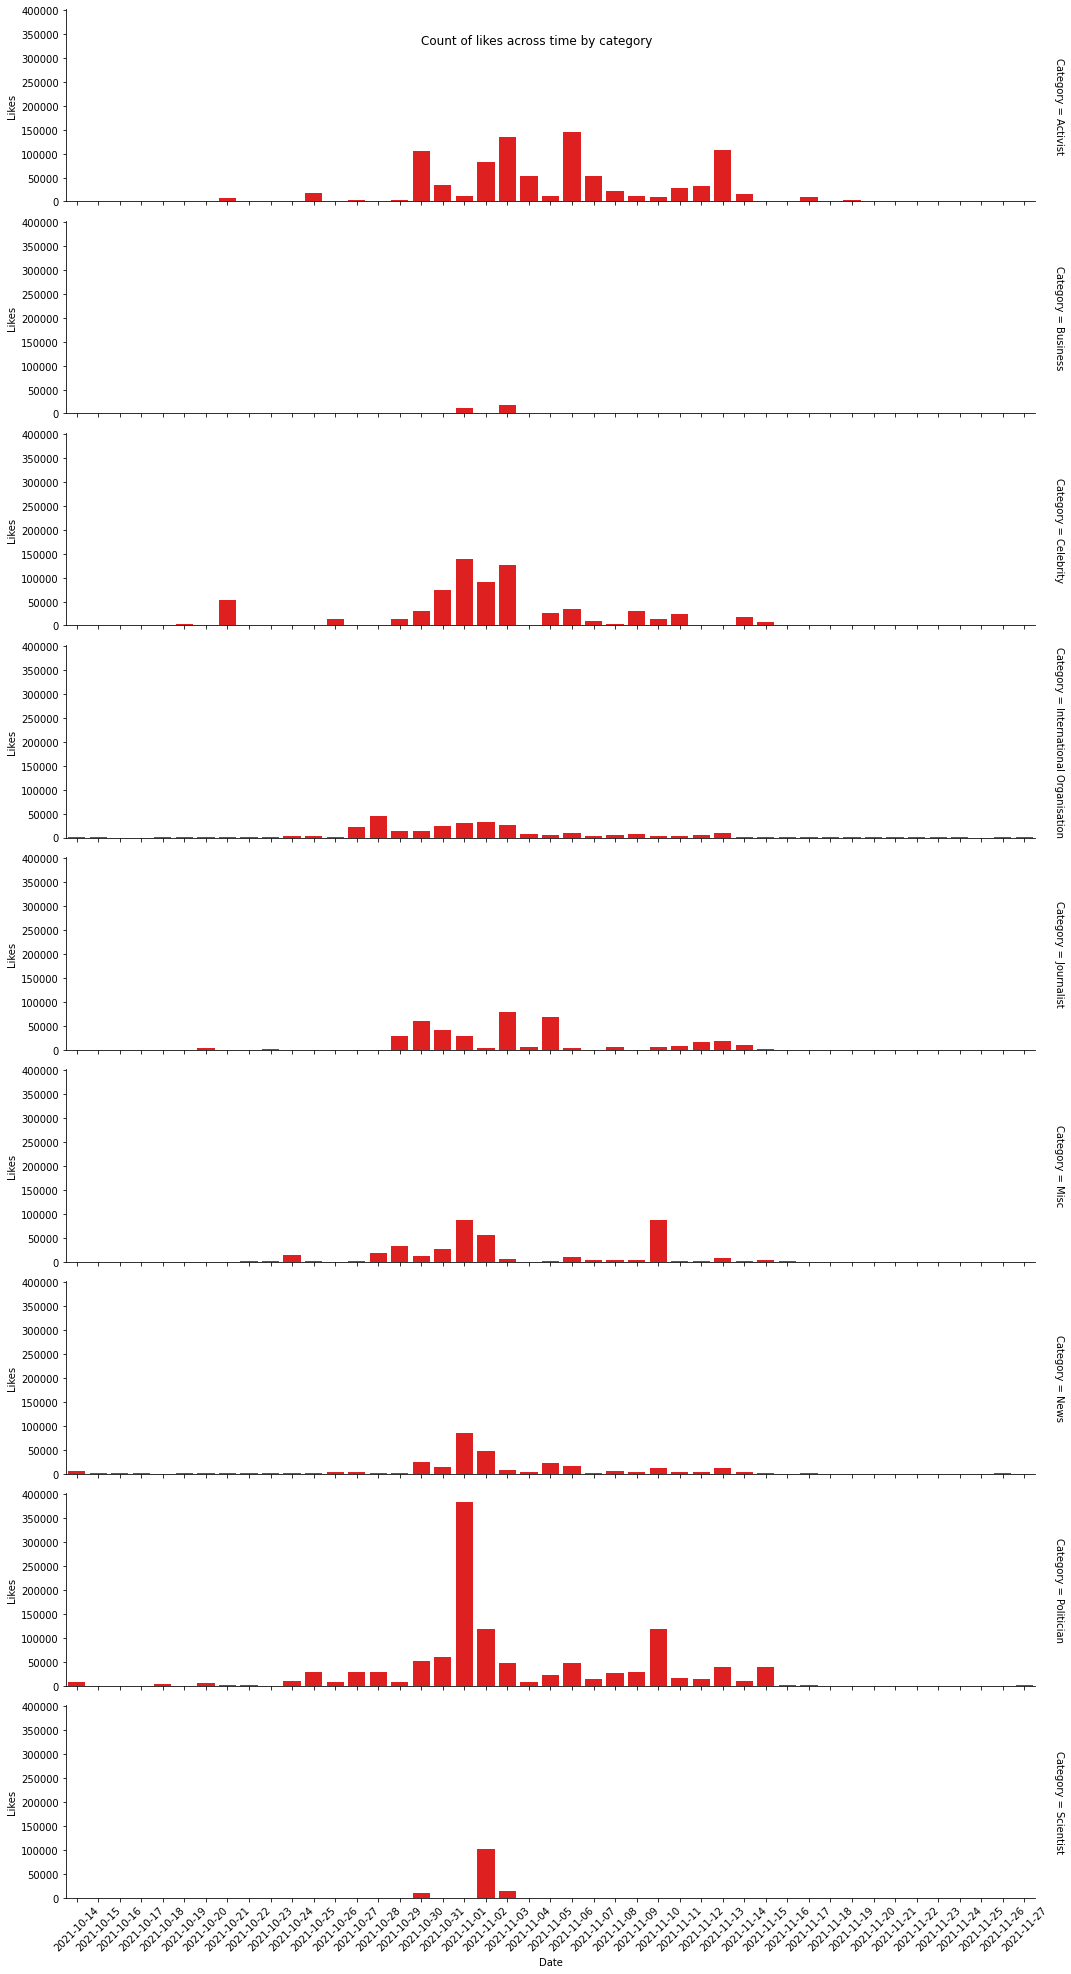

In [40]:
# Tweet Likes Across Time by Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Category"]).sum().reset_index(), row="Category", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Likes", ci=None, color="red")
g.fig.suptitle("Count of likes across time by category")
plt.xticks(rotation=45)
plt.show()

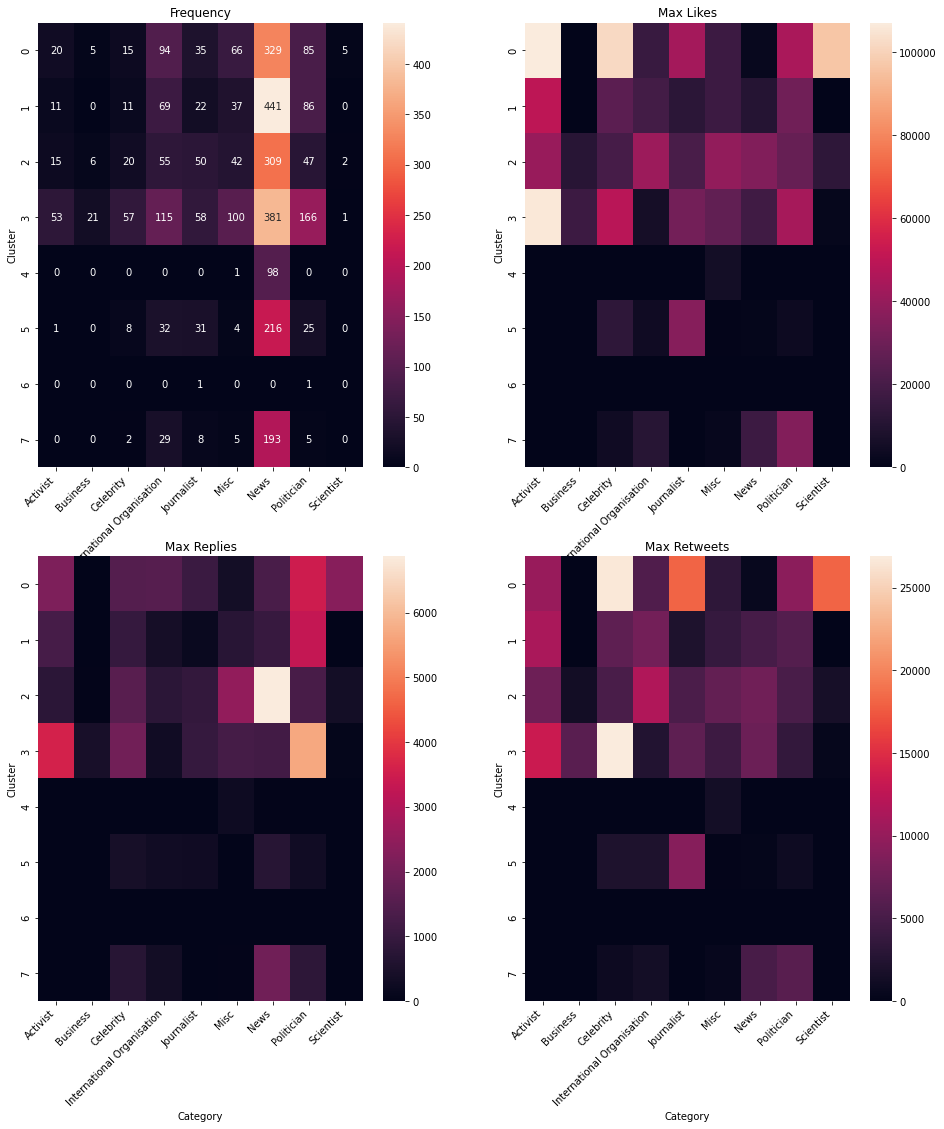

In [41]:
# Cluster-Category co-occurence matrices

plt.figure(figsize=(16,18))

plt.subplot(221)
plt.title("Frequency")
heat = sns.heatmap(tweets_df.pivot_table(values="ID",index="Cluster",columns="Category",aggfunc="count").fillna(0.0), annot=True, fmt="g")
heat.set_xticklabels(heat.get_xticklabels(), rotation=45, horizontalalignment='right')

for i, val in enumerate(["Likes","Replies","Retweets"]):
    plt.subplot(222+i)
    plt.title("Max "+val)
    heat = sns.heatmap(tweets_df.pivot_table(values=val,index="Cluster",columns="Category",aggfunc="max").fillna(0.0))
    heat.set_xticklabels(heat.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

<Figure size 1296x1152 with 0 Axes>

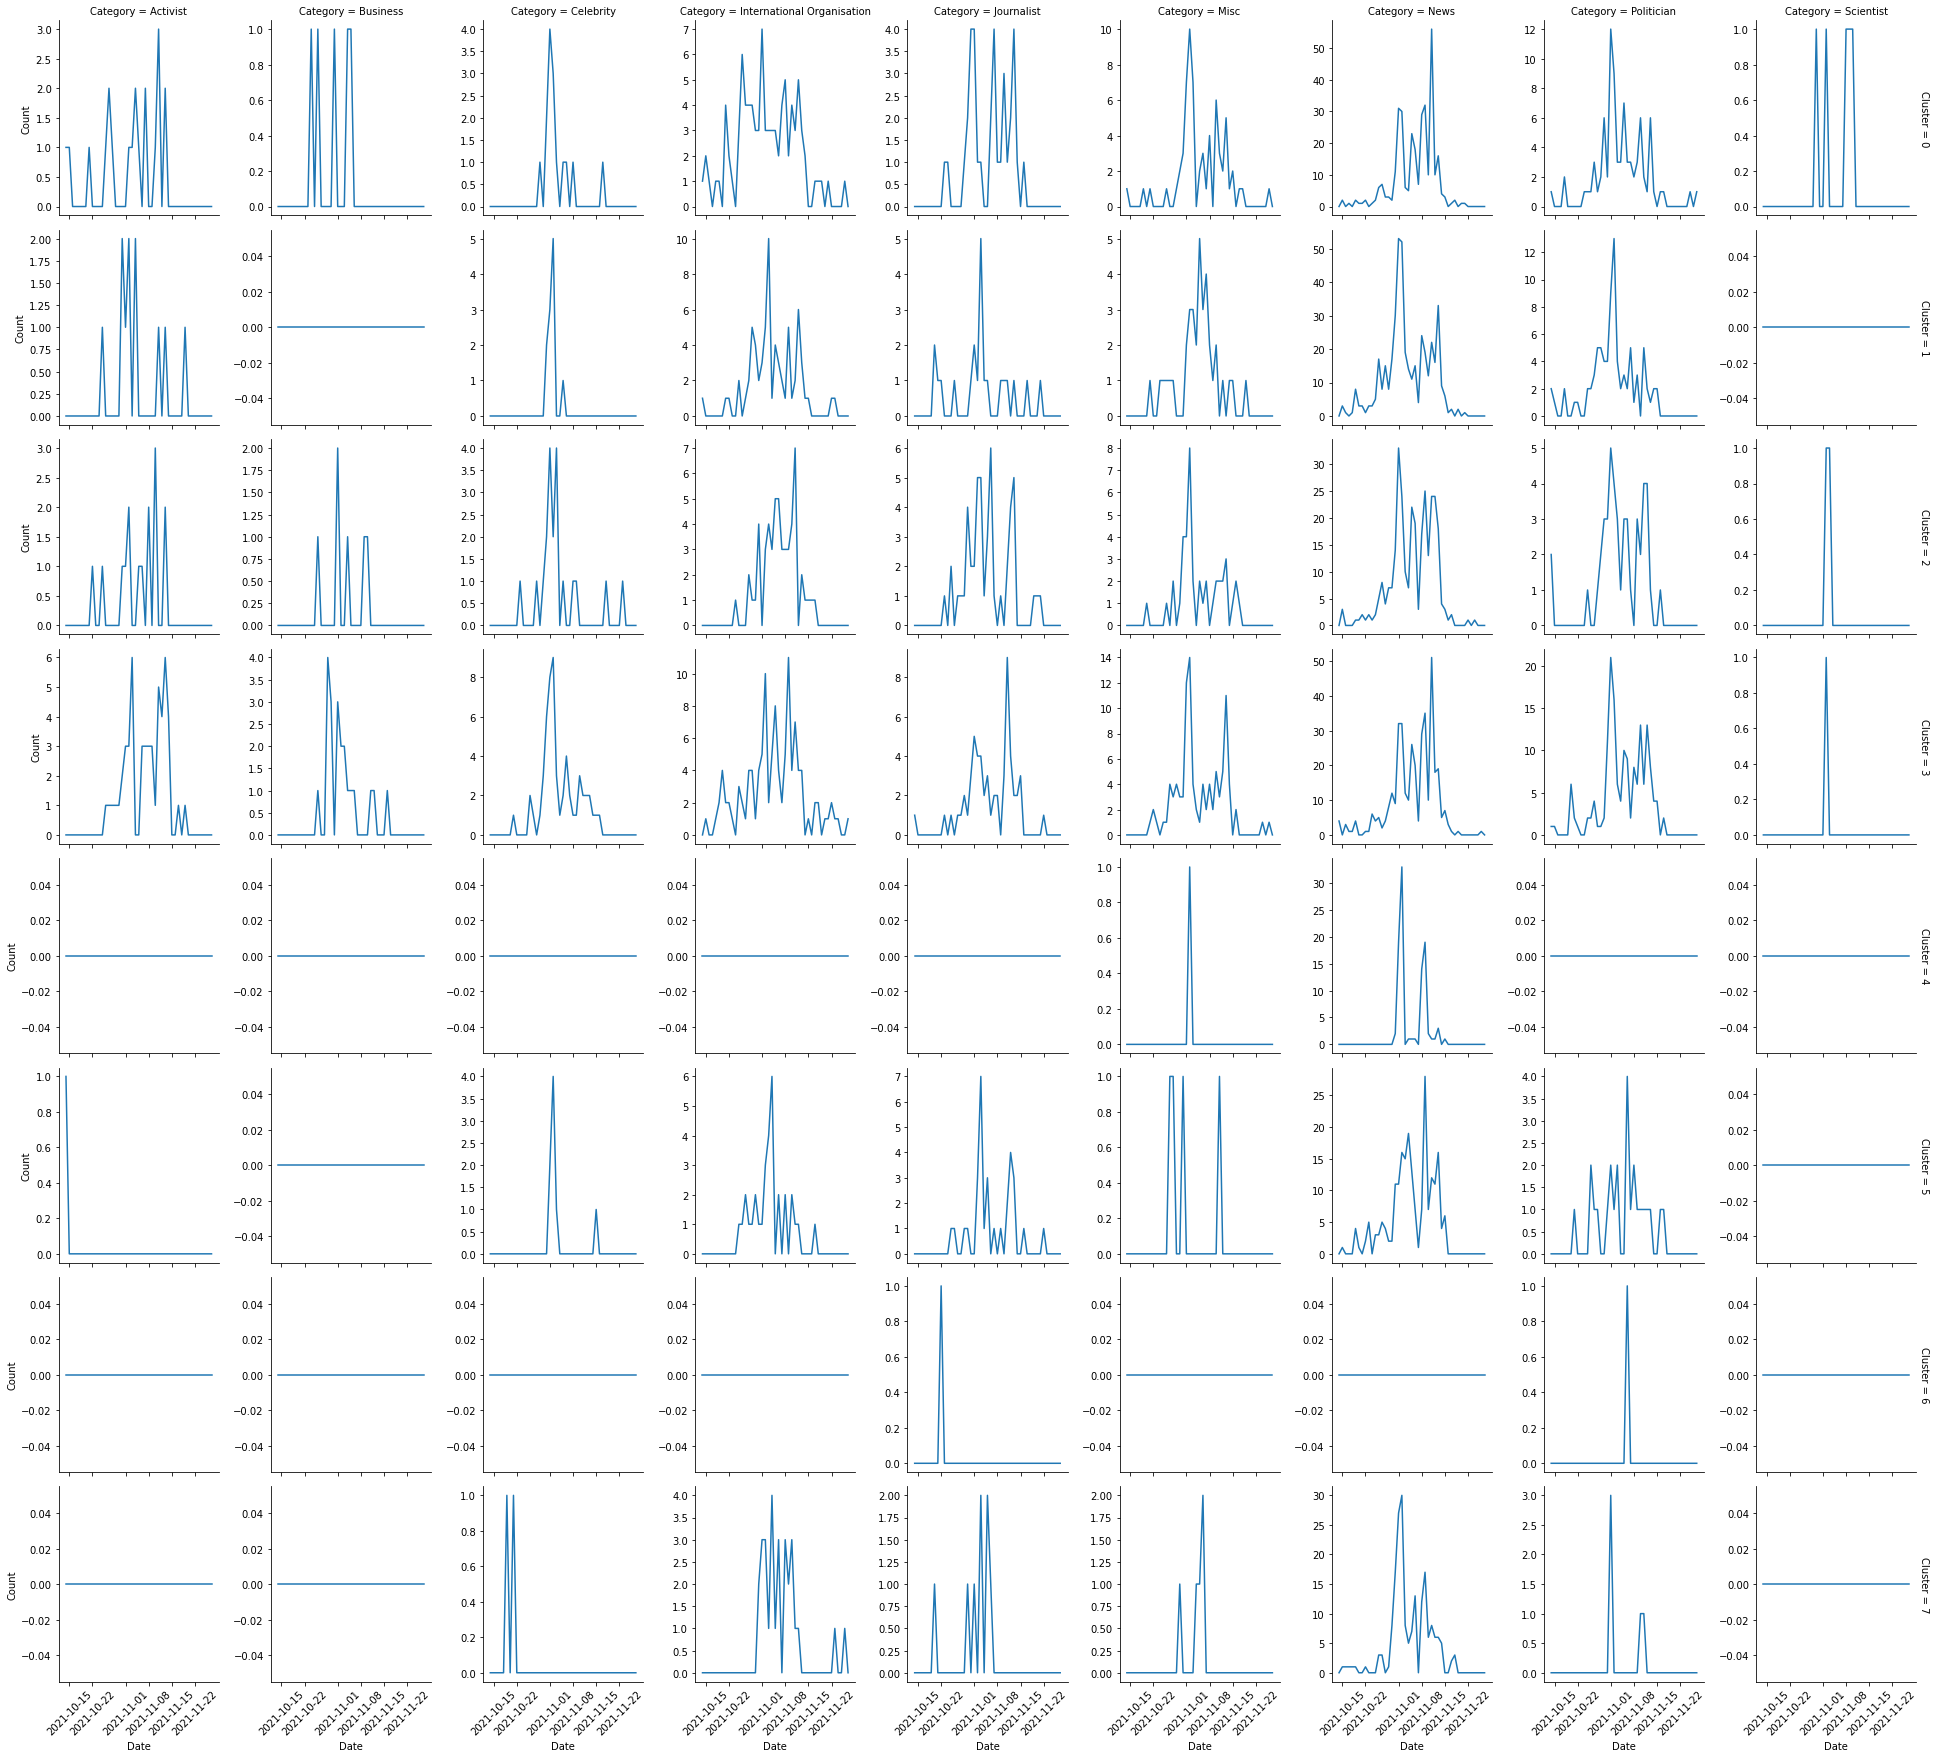

In [42]:
# Timeseries of Counts of Tweets by Cluster and Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df, row = "Cluster", col="Category", margin_titles=True, sharey=False)
g.map(sns.lineplot, "Date", "Count", err_style=None)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.show()

In [43]:
# PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
tweet_embedding_avg_matrix_pc = pca.fit_transform(tweet_embedding_avg_matrix)
tweets_df["PC1"] = tweet_embedding_avg_matrix_pc[:,0]
tweets_df["PC2"] = tweet_embedding_avg_matrix_pc[:,1]
tweets_df["PC3"] = tweet_embedding_avg_matrix_pc[:,2]

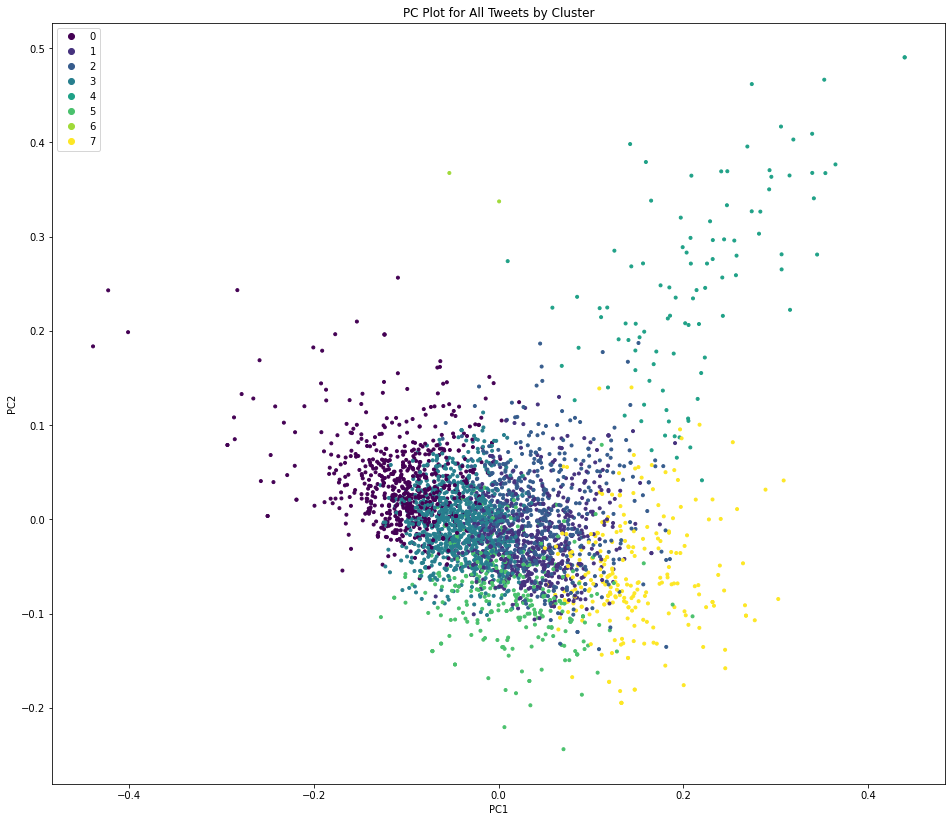

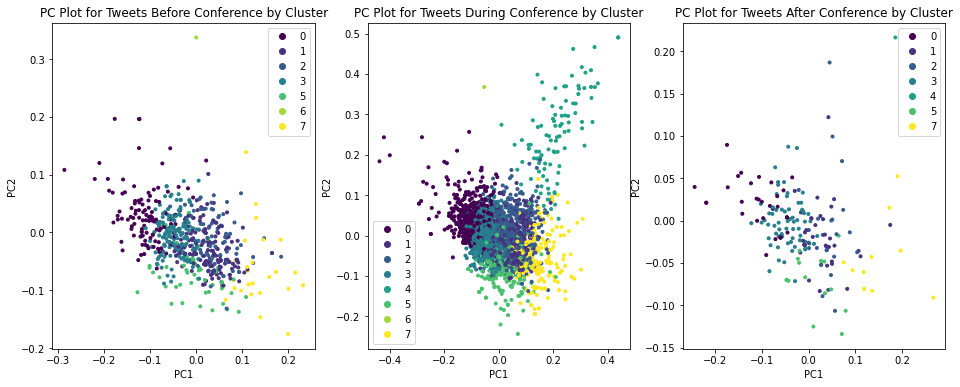

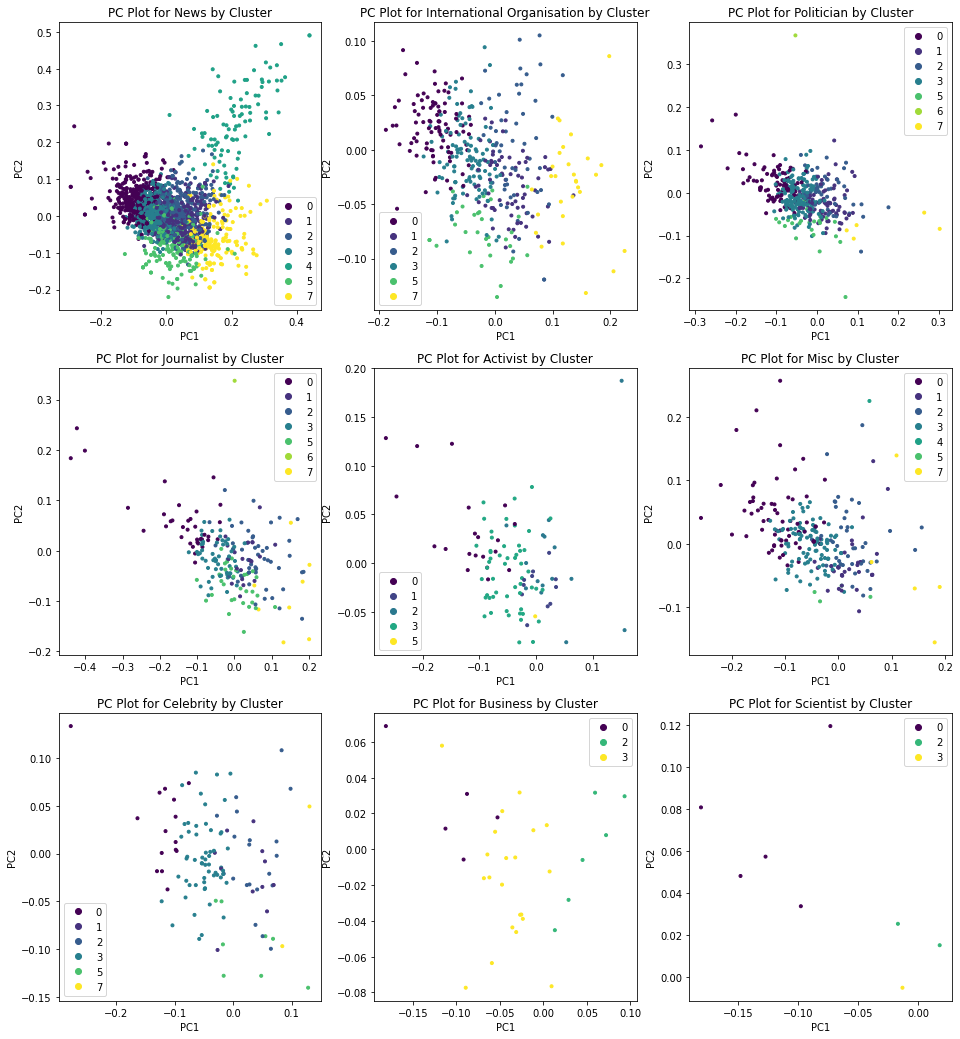

In [46]:
# PC Plots

# Organise colours
colours_unique_all, colours_scaled_all = scatter_cmap(list(tweets_df["Cluster"]))
tweets_df["colours_scaled"] = colours_scaled_all
tweets_df["period"] = tweets_df["Date"].apply(lambda x: (x >= dt.datetime.strptime("2021-10-31","%Y-%m-%d").date()) + (x > dt.datetime.strptime("2021-11-13","%Y-%m-%d").date()))

# All-time plot

plt.figure(figsize=(16,14))

scatter = plt.scatter(tweets_df["PC1"],
                      tweets_df["PC2"],
                      c=colours_scaled_all,
                      cmap = "viridis",
                      marker='.')
handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique_all)
plt.title("PC Plot for All Tweets by Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

# Plots for each period

plt.figure(figsize=(16,6))

for i, p in enumerate(["Before","During","After"]):
    plt.subplot(131+i)
    tweets_df_filtered = tweets_df[tweets_df["period"] == i]
    colours_scaled = list(tweets_df_filtered["colours_scaled"])
    colours_unique = list(set(list(tweets_df_filtered["Cluster"])))
    scatter = plt.scatter(tweets_df_filtered["PC1"],
                tweets_df_filtered["PC2"],
                c=colours_scaled,
                cmap = "viridis",
                marker='.')
    handles, labels = scatter.legend_elements()
    plt.legend(handles, colours_unique)
    plt.title("PC Plot for Tweets "+p+" Conference by Cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.show()

# Plots for each category

categories = list(tweets_df["Category"].unique())

plt.figure(figsize=(16,18))

for i, cat in enumerate(categories):
    plt.subplot(331+i)
    tweets_df_filtered = tweets_df[tweets_df["Category"] == cat]
    colours_scaled = list(tweets_df_filtered["colours_scaled"])
    colours_unique = list(set(list(tweets_df_filtered["Cluster"])))
    scatter = plt.scatter(tweets_df_filtered["PC1"],
                tweets_df_filtered["PC2"],
                c=colours_scaled,
                cmap = "viridis",
                marker='.')
    handles, labels = scatter.legend_elements()
    plt.legend(handles, colours_unique)
    plt.title("PC Plot for "+cat+" by Cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")